Data Loading

In [123]:
import pandas as pd

tracking_data = pd.read_csv("tracking_data.csv")
tracking = pd.read_csv("tracking.csv")

In [124]:
tracking_data.head()

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
0,105690,10390,16471,16471,True,-5.09,4.06
1,105690,10390,16663,16663,False,-37.38,2.30
2,105690,10390,14926,14926,False,-9.80,-4.98
3,105690,10390,24372,24372,False,-12.67,13.88
4,105690,10390,28565,28565,False,9.64,-27.23


In [125]:
tracking.head()

,MATCH_ID,FRAME,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,IMAGE_CORNERS_PROJECTION,TIMESTAMP,PERIOD
0,105690,0,NaN,NaN,[],NaN,NaN
1,105690,1,NaN,NaN,"[-39.64771619718988,39,-15.330777205830284,-39...",NaN,NaN
2,105690,2,NaN,NaN,"[-39.53509099528044,39,-15.02475615465837,-39....",NaN,NaN
3,105690,3,NaN,NaN,"[-38.87446954611893,39,-15.3418580847785,-39.9...",NaN,NaN
4,105690,4,NaN,NaN,"[-39.02694398852428,39,-15.241715150701653,-39...",NaN,NaN


Lösche Daten zu denen es keine korrespondierenden tracking_data gibt. Wir wollen nur echte Spielzeitpunkte analysieren.

In [126]:
valide_frames = tracking_data['FRAME'].unique()
tracking = tracking[tracking['FRAME'].isin(valide_frames)]

In [127]:
tracking['POSSESSION_TRACKABLE_OBJECT'] = tracking['POSSESSION_TRACKABLE_OBJECT'].astype('Int64')

Konvertiere in Datentyp, der Zeit unterstützt.

In [128]:
tracking['TIME_DELTA'] = pd.to_timedelta(tracking['TIMESTAMP'])

Finde Anpfiffzeitpunkt. (Frame Nummer des Anpfiffs)

In [129]:
anpfiff_time = pd.to_timedelta("0:00:00")
anpfiff_frame = tracking.loc[tracking['TIME_DELTA'] >= anpfiff_time, 'FRAME'].min()

In [130]:
tracking_data[tracking_data["FRAME"] == anpfiff_frame]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
901153,105690,60,29938,29938,False,41.41,-0.12
901154,105690,60,28540,28540,True,15.72,2.70
901155,105690,60,28548,28548,True,16.38,-6.11
901156,105690,60,16641,16641,False,16.93,16.02
901157,105690,60,29942,29942,True,14.86,-17.57
901158,105690,60,39015,39015,False,8.73,-2.07
901159,105690,60,28546,28546,True,9.23,-10.42
901160,105690,60,28547,28547,True,8.41,4.39
901161,105690,60,16427,16427,True,1.08,10.88
901162,105690,60,28437,28437,True,8.07,-16.70


In [131]:
start_spieler = tracking_data[
    (tracking_data["FRAME"] == anpfiff_frame) &
    (tracking_data["TRACK_ID"] != 55)
]

In [132]:
len(tracking_data['TRACKABLE_OBJECT'].unique())

30

Insgesamt spielen 30 "Objekte" mit, d.h. es gibt insgesamt vermutlich 7 Auswechsunglen

## Zuordnung der Spieler zu Teams

Variante 1: Spielerposition bei Antoss

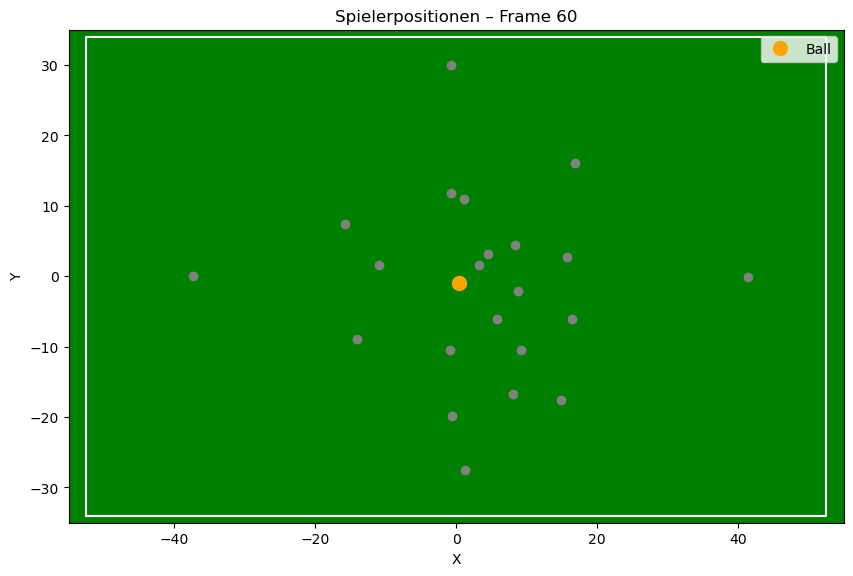

In [133]:
import matplotlib.pyplot as plt

def plot_spieler(tracking_df, frame, team0_ids=None, team1_ids=None, ball_id=55):
    df = tracking_df[tracking_df['FRAME'] == frame]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Spielfeld zeichnen (vereinfachtes Rechteck)
    ax.set_facecolor('green')
    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

    ax.set_xlim(-55, 55)
    ax.set_ylim(-35, 35)
    ax.set_aspect('equal')

    # Flags, um Label nur einmal hinzuzufügen
    ball_plotted = False
    team0_plotted = False
    team1_plotted = False

    for _, row in df.iterrows():
        if row['TRACK_ID'] == ball_id:
            if not ball_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball')
                ball_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10)
        elif team0_ids and row['TRACK_ID'] in team0_ids:
            if not team0_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts')
                team0_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='blue')
        elif team1_ids and row['TRACK_ID'] in team1_ids:
            if not team1_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim')
                team1_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='red')
        else:
            ax.plot(row['X'], row['Y'], 'o', color='gray')

    plt.title(f"Spielerpositionen – Frame {frame}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc='upper right')
    plt.show()


plot_spieler(tracking_data, anpfiff_frame)

In [134]:
tracking_data[(tracking_data["FRAME"] == anpfiff_frame) & (tracking_data['X'] > 0)].shape

(15, 7)

Variante 2: Nehme tracking und setze Team zu Ballbesitz Team und Trackable object

In [135]:
import pandas as pd

ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())

In [136]:
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

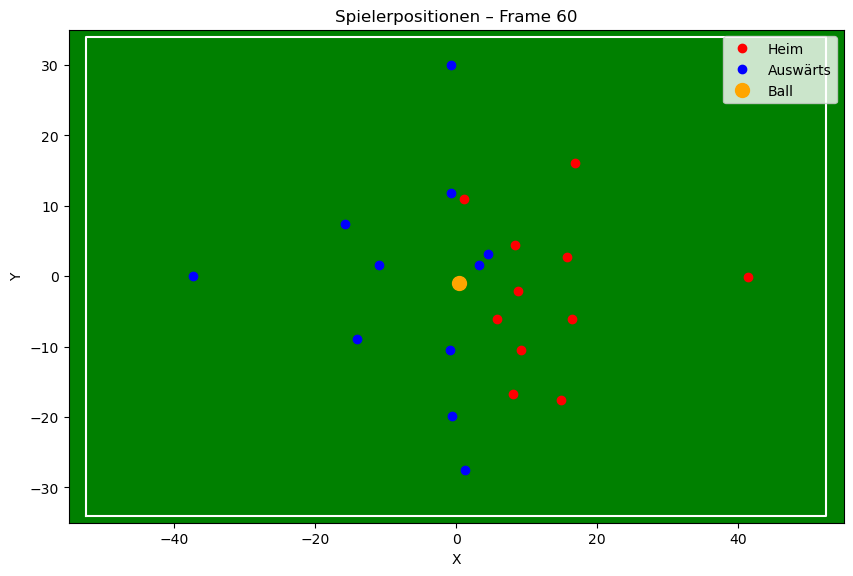

In [137]:
plot_spieler(tracking_data, anpfiff_frame, team0_ids=away_team_ids, team1_ids=home_team_ids)

Wir wissen nun, das Heimteam spielt in der ersten Halbzeit von rechts nach links.

In [220]:
halbzeit_frame = tracking[tracking['PERIOD'] == 2]['FRAME'].iloc[0]

In [221]:
halbzeit_frame

27690

## Bewegungsprofile

In [138]:
tracking_data_with_period_and_team = tracking_data.merge(tracking[['FRAME', 'PERIOD', 'POSSESSION_GROUP']], on='FRAME', how='left')

In [208]:
ball = tracking_data_with_period_and_team[(tracking_data_with_period_and_team['TRACK_ID'] == 39023) & (tracking_data_with_period_and_team['PERIOD'] == 1)]

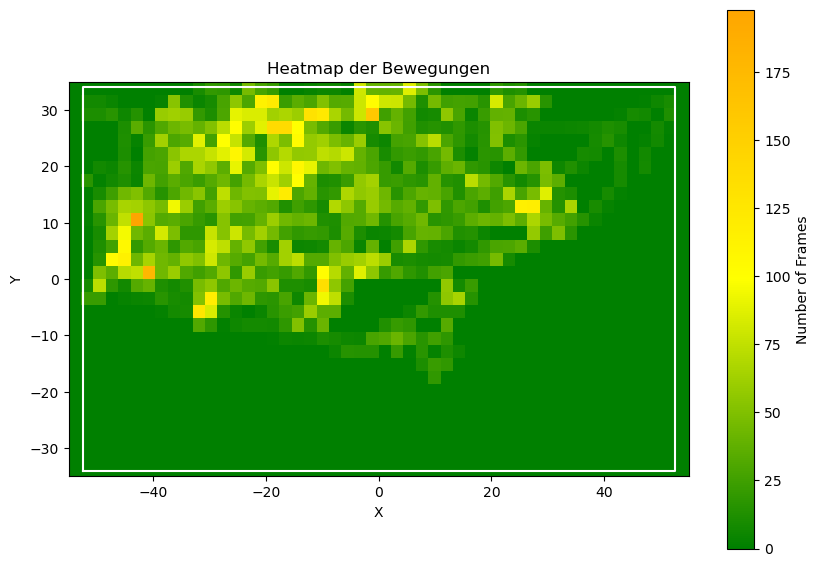

In [215]:
from matplotlib.colors import LinearSegmentedColormap

green_red_cmap = LinearSegmentedColormap.from_list("green_red", ["green", "yellow", "orange"])

plt.figure(figsize=(10, 7))
plt.title("Heatmap der Bewegungen")

plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
plt.xlim(-55, 55)
plt.ylim(-35, 35)
plt.gca().set_facecolor("green")

plt.hist2d(
    ball['X'],
    ball['Y'],
    bins=[50, 30],           # Anzahl der Bins in X und Y (quadratisch = gleiche Zahl)
    range=[[-55, 55], [-35, 35]],  # Spielfeldgrenzen
    cmap=green_red_cmap
)
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.colorbar(label='Number of Frames')
plt.show()

## Tor erkennen

Suche nach Frames in denen die Ballposition in einem für ein Tor passendem Rechteck ist. Bei einem Tor wird der Ball auf jeden Fall durch die Kameras sichtbar sein.

In [217]:
tracking_ball = tracking_data[tracking_data['TRACK_ID'] == 55]

In [236]:
tracking_ball[(tracking_ball['IS_VISIBLE'] == True) & (tracking_ball['X'] < 53) & (tracking_ball['X'] > 51.5) & (tracking_ball['Y'] < 5) & (tracking_ball['Y'] > -5)]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
529403,105690,37527,55,55,True,52.00,2.45
529426,105690,37528,55,55,True,52.57,2.61


In [237]:
tracking_ball[(tracking_ball['IS_VISIBLE'] == True) & (tracking_ball['X'] > -53) & (tracking_ball['X'] < -51.5) & (tracking_ball['Y'] < 5) & (tracking_ball['Y'] > -5)]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
63745,105690,13663,55,55,True,-51.86,1.49
63768,105690,13664,55,55,True,-52.51,2.05
146614,105690,17881,55,55,True,-51.55,4.12
146637,105690,17882,55,55,True,-51.61,4.44
146660,105690,17883,55,55,True,-51.80,4.68
146683,105690,17884,55,55,True,-51.88,4.77
146706,105690,17885,55,55,True,-51.88,4.81
146729,105690,17886,55,55,True,-51.74,4.88
146752,105690,17887,55,55,True,-51.64,4.93
146775,105690,17888,55,55,True,-51.70,4.86


Es erscheint nur plausibel, dass ein Tor zwischen Frames 19677 und 19711 gefallen ist, da hier der Ball im Tor liegen bleibt und der Ball sichtbar ist für die Kameras.  
Allerdings ist danach kein Anstoß zu erkennen, das Spiel läuft normal weiter. 

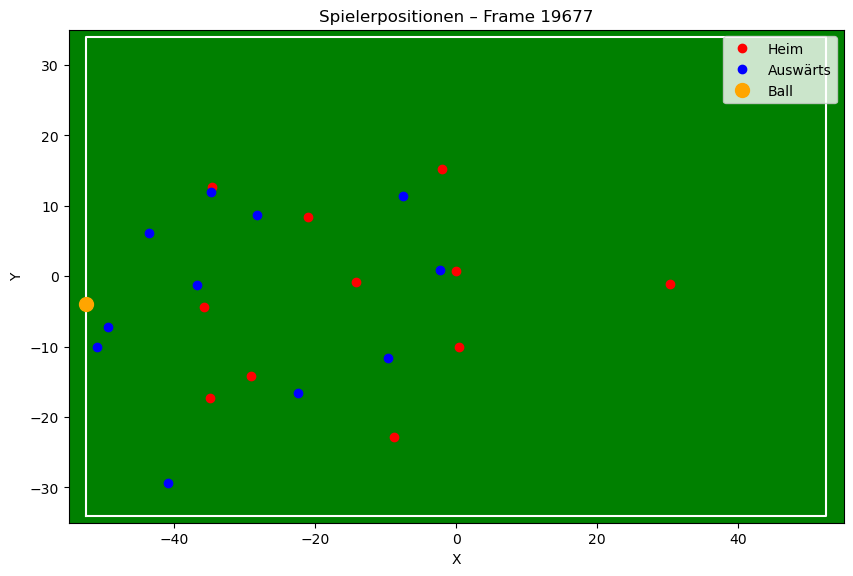

In [241]:
plot_spieler(tracking_data, 19677, away_team_ids, home_team_ids)

## Alternative: Anstoß erkennen

In [246]:
ball_mitte = tracking_ball[
    (tracking_ball['IS_VISIBLE'] == True) &
    (tracking_ball['X'].abs() < 1) &
    (tracking_ball['Y'].abs() < 1)
].copy()

In [247]:
ball_mitte

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
320172,105690,26948,55,55,True,-0.66,0.79
370450,105690,29381,55,55,True,0.70,0.79
370473,105690,29382,55,55,True,0.16,0.39
370496,105690,29383,55,55,True,-0.35,0.00
370519,105690,29384,55,55,True,-0.86,-0.40
421671,105690,31714,55,55,True,-0.69,-0.32
421694,105690,31715,55,55,True,0.01,-0.59
421717,105690,31716,55,55,True,0.73,-0.85
582740,105690,40661,55,55,True,0.81,-0.36
582763,105690,40662,55,55,True,0.03,-0.99
